<a href="https://colab.research.google.com/github/smartsinovich/Stepik_NeuralNetworks_and_ComputerVision/blob/master/Stepik_seminar_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Реализация сети LeNet (1998, ЛеКун) для решения задачи MNIST

![alt text](https://camo.githubusercontent.com/d464ca86de08d7173fcccc38ec0c840a6da02cea/68747470733a2f2f656e676d726b2e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031382f30392f4c654e65745f4f726967696e616c5f496d6167652e6a7067)

![alt text](https://camo.githubusercontent.com/9028f39092178a1b65f243eb8b471ebd84920cec/68747470733a2f2f656e676d726b2e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031382f30392f4c654e45745f53756d6d6172795f5461626c652e6a7067)

In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets

In [4]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

  0%|          | 16384/9912422 [00:00<01:30, 109525.50it/s]

9920512it [00:00, 29053016.56it/s]                           


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 461039.00it/s]
  1%|          | 16384/1648877 [00:00<00:11, 144153.02it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7534073.37it/s]                            
8192it [00:00, 186209.44it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [5]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [6]:
len(y_train), len(y_test)

(60000, 10000)

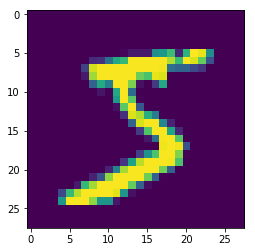

tensor(5)


In [7]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
#в полносвязную сеть мы передавали 1-мерн тензор
#в эту (конвулюционную) сеть мы будем передавать 3-мерн тензор
#надо добавить еще одно измерение - каналы
#картинка ч/б - 1 канал
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [9]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [0]:
#5 обучающих слоев
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        #1-я конволюция
        #Conv2d - свертка в 2-мерн пр-ве (есть еще Conv3d)
        #in_channels - входные каналы
        #out_channels - выходные каналы
        #kernel_size - размер маски (ядра свертки) - мб не квадратная, тогда указываем [x,y]
        #padding - паддинг
        #в оригинале картинки 32*32, а у нас 28*28
        #мы не хотим терять размерность картинки, поэтому паддинг=2 (в оригинале паддинга нет)
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        #Average Pulling
        #параметры: kernel_size=2 - пуллинг 2*2
        #stride=2 - значит, без пересечений
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        #оригинальная архитектура
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        #получился 3-мерн тензор 5*5*16
        #здесь мы растянем изображение в вектор (в ф-ции forward)
        #в полносвязный слой идет вектор
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        #x - батч из картинок
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        #растягиваем тензор (он, на самом деле, 4-мерн, 1-я размерность - размер батча)
        #получает 2-мерн тензор, 1-я разм-ть - размер батча, 2-я разм-ть - все пиксели
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
#нет параметров для инизиализации
lenet5 = LeNet5()

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [13]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    
    #в прошлый раз тут была утечка памяти:
    #loss(test_preds, y_test) - хранит весь граф вычислений, кот нам не нужен
    #loss(test_preds, y_test).data  - хнанит только скаляр
    #loss(test_preds, y_test).data.cpu() - перенесем на Cpu, чтобы не занимало место на Gpu
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9776)
tensor(0.9827)
tensor(0.9857)
tensor(0.9873)
tensor(0.9885)
tensor(0.9879)
tensor(0.9875)
tensor(0.9879)
tensor(0.9887)


KeyboardInterrupt: ignored

Эпохи проходят долго, но это нормально. У сети нескольно десятков тысяч параметров.
БОльшая часть времени тратится на передачу датасета на gpu.

Видим, что качество перестает расти, значит сеть может переобучиться.
Сеть состоит наполовину из конвулюционной сети, наполовину из полносвязной. Полносвязные сети более склонны к переобучению.

In [14]:
lenet5.forward(X_test)

tensor([[-1.7973,  0.3095, -0.6095,  ..., 13.7927, -2.6326,  3.4203],
        [ 0.8508, -0.0235, 13.9981,  ..., -3.3056,  2.5753, -4.4224],
        [-2.0731, 14.1936, -3.4811,  ...,  1.7194,  1.9367, -1.6852],
        ...,
        [-4.5734, -1.0577, -2.6787,  ...,  0.3855,  0.3943,  3.9777],
        [-1.4309, -4.8156, -4.1895,  ..., -5.9783,  6.0627, -0.5814],
        [ 1.1557, -5.0591,  0.8996,  ..., -6.7149, -0.9079, -2.6496]],
       device='cuda:0', grad_fn=<AddmmBackward>)

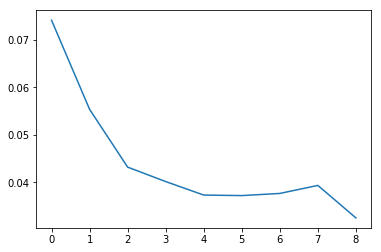

In [15]:
plt.plot(test_loss_history);

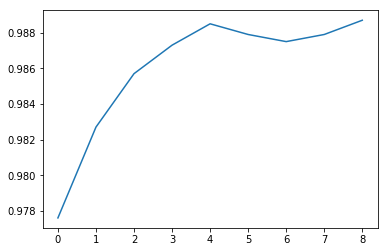

In [16]:
plt.plot(test_accuracy_history);